Neste exemplo faremos um algoritmo de aprendizado para a base de dados heart-failure.

Importando as bibliotecas e a base de dados:

In [30]:
from sklearn.metrics import classification_report , ConfusionMatrixDisplay, confusion_matrix, precision_recall_curve, roc_curve, RocCurveDisplay
from sklearn.tree import DecisionTreeClassifier, plot_tree 
from sklearn.model_selection import train_test_split,GridSearchCV, cross_val_score
from sklearn.linear_model import LogisticRegression
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

In [3]:
df=pd.read_excel('heart_failure.xlsx')

Realizamos de início a divisão das colunas a serem usadas e o split entre dados de treino e teste, para evitar data leakage:

In [4]:
df.head()

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT
0,75.0,0.0,582.0,0.0,20.0,1.0,265000.00,2022-09-01 00:00:00,130.0,1.0,0.0,4.0,1.0
1,55.0,0.0,7861.0,0.0,38.0,0.0,263358.03,2022-01-01 00:00:00,136.0,1.0,0.0,6.0,1.0
2,65.0,0.0,146.0,0.0,20.0,0.0,162000.00,2022-03-01 00:00:00,129.0,1.0,1.0,7.0,1.0
3,50.0,1.0,111.0,0.0,20.0,0.0,210000.00,2022-09-01 00:00:00,137.0,1.0,0.0,7.0,1.0
4,65.0,1.0,160.0,1.0,20.0,0.0,327000.00,2022-07-02 00:00:00,116.0,0.0,0.0,8.0,1.0


In [5]:
y=df['DEATH_EVENT'].copy()
X=df.drop(['serum_creatinine','DEATH_EVENT'],axis='columns').copy()
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.3,random_state=42)

Façamos então a primeira EDA sobre os dados de treino:

In [6]:
X_train.head()

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_sodium,sex,smoking,time
224,58.0,0.0,582.0,1.0,25.0,0.0,504000.0,138.0,1.0,0.0,205.0
68,70.0,0.0,161.0,0.0,25.0,0.0,244000.0,142.0,0.0,0.0,66.0
222,42.0,1.0,86.0,0.0,35.0,0.0,365000.0,139.0,1.0,1.0,201.0
37,82.0,1.0,855.0,1.0,50.0,1.0,321000.0,145.0,0.0,0.0,30.0
16,87.0,1.0,149.0,0.0,38.0,0.0,262000.0,140.0,1.0,0.0,14.0


In [7]:
X_train.isnull().sum()

age                         0
anaemia                     0
creatinine_phosphokinase    0
diabetes                    0
ejection_fraction           0
high_blood_pressure         0
platelets                   0
serum_sodium                0
sex                         0
smoking                     0
time                        0
dtype: int64

In [8]:
X_train.describe()

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_sodium,sex,smoking,time
count,209.000000,209.000000,209.000000,209.000000,209.000000,209.000000,209.000000,209.000000,209.000000,209.000000,209.000000
mean,350.746411,0.421053,575.320574,0.397129,38.411483,0.354067,262121.389713,136.717703,0.631579,0.301435,133.545455
std,4192.237254,0.494913,925.957679,0.490478,11.571810,0.479378,91141.626476,4.318088,0.483535,0.459983,78.094919
min,40.000000,0.000000,23.000000,0.000000,20.000000,0.000000,62000.000000,113.000000,0.000000,0.000000,4.000000
25%,52.000000,0.000000,110.000000,0.000000,30.000000,0.000000,210000.000000,134.000000,0.000000,0.000000,76.000000
50%,60.000000,0.000000,245.000000,0.000000,38.000000,0.000000,263000.000000,137.000000,1.000000,0.000000,119.000000
75%,68.000000,1.000000,582.000000,1.000000,45.000000,1.000000,305000.000000,140.000000,1.000000,1.000000,206.000000
max,60667.000000,1.000000,7861.000000,1.000000,80.000000,1.000000,621000.000000,146.000000,1.000000,1.000000,285.000000


In [10]:
#Verificando se há desbalanceamento no target
y_train.value_counts(normalize=True)

0.0    0.717703
1.0    0.282297
Name: DEATH_EVENT, dtype: float64

Percebe-se que há um certo desbalanceamento nas classes do target, e não há presença de nulos e dados não numéricos para serem tratados. Façamos a análise com os dados originais para verificar os resultados:

### Regressão Logística:

O primeiro modelo será feito com uma regressão logística. Será aplicado o gridsearch com 5 cross_validations, para buscar os melhores parâmetros de predição para o modelo:

              precision    recall  f1-score   support

         0.0       0.73      0.96      0.83        53
         1.0       0.90      0.49      0.63        37

    accuracy                           0.77        90
   macro avg       0.81      0.72      0.73        90
weighted avg       0.80      0.77      0.75        90



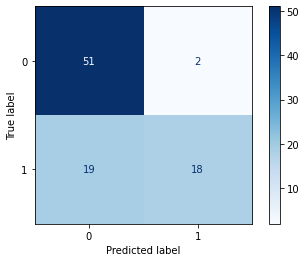

In [12]:
logit=LogisticRegression()
logit_params = {'penalty':['l1','l2','elasticnet'],
                'C':np.logspace(-4,4,20),
                'solver':['liblinear','saga']}
logit_cv=GridSearchCV(logit,logit_params,n_jobs=-1,cv=5)
logit_cv.fit(X_train,y_train)
y_pred=logit_cv.predict(X_test)
logit_cm=confusion_matrix(y_test, y_pred)
print(classification_report(y_test, y_pred))
ConfusionMatrixDisplay(logit_cm).plot(cmap='Blues')
plt.show()

Percebe-se que o modelo não está sendo muito efetivo para a predição de problemas cardíacos, uma vez que ainda que a taxa de falsos positivos seja baixa, há quase 50% de falsos negativos. Vejamos a curva ROC:

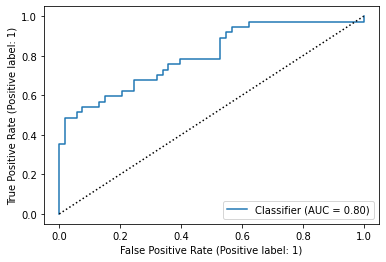

In [32]:
y_proba_1 = logit_cv.predict_proba(X_test)[:, 1]
fpr, tpr, cutoffs = roc_curve(y_test, y_proba_1)
RocCurveDisplay.from_predictions(y_test, y_proba_1)
x = np.linspace(0, 1, 2)
plt.plot(x, x, color="k", ls=":");

Vejamos como se comporta o modelo com a variação do cutoff. Serão adicionados a um dicionário os resultados da média ponderada dos f1-score para cada valor de cutoff, assim avaliaremos o melhor caso:


Cutoff: 0.1
              precision    recall  f1-score   support

         0.0       0.89      0.45      0.60        53
         1.0       0.54      0.92      0.68        37

    accuracy                           0.64        90
   macro avg       0.71      0.69      0.64        90
weighted avg       0.75      0.64      0.63        90



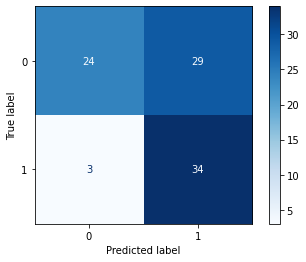

Cutoff: 0.15
              precision    recall  f1-score   support

         0.0       0.78      0.47      0.59        53
         1.0       0.52      0.81      0.63        37

    accuracy                           0.61        90
   macro avg       0.65      0.64      0.61        90
weighted avg       0.67      0.61      0.61        90



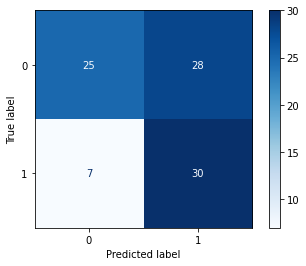

Cutoff: 0.2
              precision    recall  f1-score   support

         0.0       0.78      0.53      0.63        53
         1.0       0.54      0.78      0.64        37

    accuracy                           0.63        90
   macro avg       0.66      0.66      0.63        90
weighted avg       0.68      0.63      0.63        90



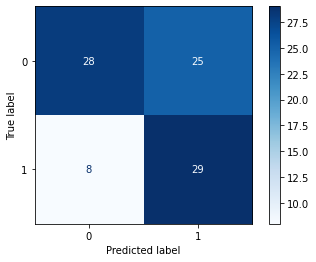

Cutoff: 0.25
              precision    recall  f1-score   support

         0.0       0.80      0.60      0.69        53
         1.0       0.58      0.78      0.67        37

    accuracy                           0.68        90
   macro avg       0.69      0.69      0.68        90
weighted avg       0.71      0.68      0.68        90



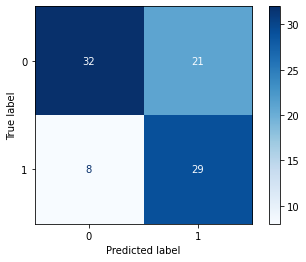

Cutoff: 0.3
              precision    recall  f1-score   support

         0.0       0.75      0.68      0.71        53
         1.0       0.60      0.68      0.63        37

    accuracy                           0.68        90
   macro avg       0.67      0.68      0.67        90
weighted avg       0.69      0.68      0.68        90



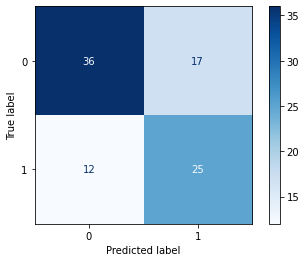

Cutoff: 0.35
              precision    recall  f1-score   support

         0.0       0.76      0.74      0.75        53
         1.0       0.64      0.68      0.66        37

    accuracy                           0.71        90
   macro avg       0.70      0.71      0.70        90
weighted avg       0.71      0.71      0.71        90



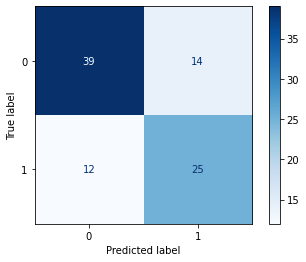

Cutoff: 0.4
              precision    recall  f1-score   support

         0.0       0.75      0.83      0.79        53
         1.0       0.71      0.59      0.65        37

    accuracy                           0.73        90
   macro avg       0.73      0.71      0.72        90
weighted avg       0.73      0.73      0.73        90



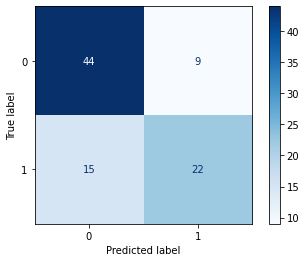

Cutoff: 0.45
              precision    recall  f1-score   support

         0.0       0.73      0.92      0.82        53
         1.0       0.83      0.51      0.63        37

    accuracy                           0.76        90
   macro avg       0.78      0.72      0.72        90
weighted avg       0.77      0.76      0.74        90



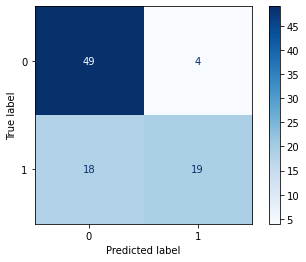

Cutoff: 0.5
              precision    recall  f1-score   support

         0.0       0.73      0.96      0.83        53
         1.0       0.90      0.49      0.63        37

    accuracy                           0.77        90
   macro avg       0.81      0.72      0.73        90
weighted avg       0.80      0.77      0.75        90



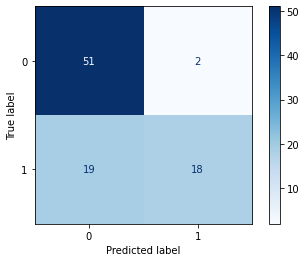

Cutoff: 0.55
              precision    recall  f1-score   support

         0.0       0.71      0.98      0.83        53
         1.0       0.94      0.43      0.59        37

    accuracy                           0.76        90
   macro avg       0.83      0.71      0.71        90
weighted avg       0.81      0.76      0.73        90



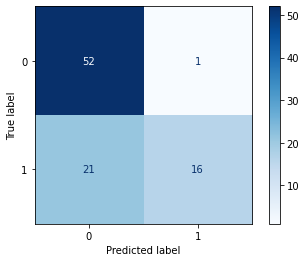

Cutoff: 0.6
              precision    recall  f1-score   support

         0.0       0.68      0.98      0.81        53
         1.0       0.93      0.35      0.51        37

    accuracy                           0.72        90
   macro avg       0.81      0.67      0.66        90
weighted avg       0.78      0.72      0.68        90



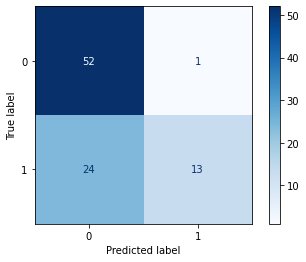

Cutoff: 0.65
              precision    recall  f1-score   support

         0.0       0.63      1.00      0.77        53
         1.0       1.00      0.16      0.28        37

    accuracy                           0.66        90
   macro avg       0.82      0.58      0.53        90
weighted avg       0.78      0.66      0.57        90



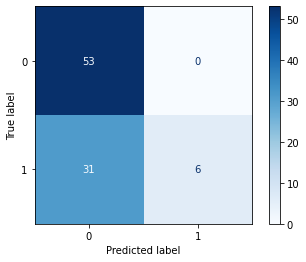

Cutoff: 0.7
              precision    recall  f1-score   support

         0.0       0.60      1.00      0.75        53
         1.0       1.00      0.05      0.10        37

    accuracy                           0.61        90
   macro avg       0.80      0.53      0.43        90
weighted avg       0.77      0.61      0.48        90



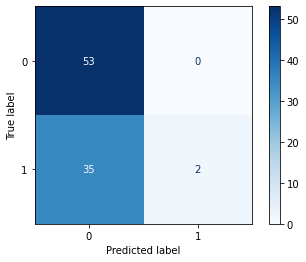

Cutoff: 0.75
              precision    recall  f1-score   support

         0.0       0.59      1.00      0.74        53
         1.0       0.00      0.00      0.00        37

    accuracy                           0.59        90
   macro avg       0.29      0.50      0.37        90
weighted avg       0.35      0.59      0.44        90



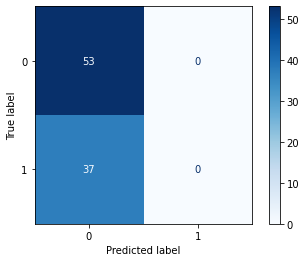

Cutoff: 0.8
              precision    recall  f1-score   support

         0.0       0.59      1.00      0.74        53
         1.0       0.00      0.00      0.00        37

    accuracy                           0.59        90
   macro avg       0.29      0.50      0.37        90
weighted avg       0.35      0.59      0.44        90



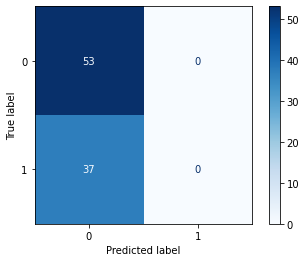

Cutoff: 0.85
              precision    recall  f1-score   support

         0.0       0.59      1.00      0.74        53
         1.0       0.00      0.00      0.00        37

    accuracy                           0.59        90
   macro avg       0.29      0.50      0.37        90
weighted avg       0.35      0.59      0.44        90



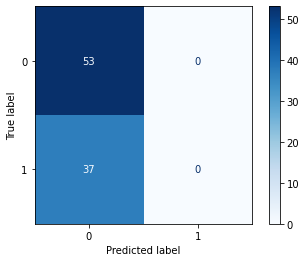

Cutoff: 0.9
              precision    recall  f1-score   support

         0.0       0.59      1.00      0.74        53
         1.0       0.00      0.00      0.00        37

    accuracy                           0.59        90
   macro avg       0.29      0.50      0.37        90
weighted avg       0.35      0.59      0.44        90



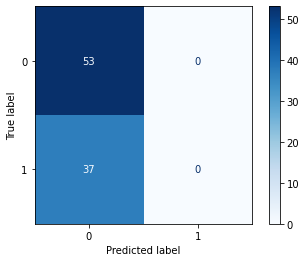

Cutoff: 0.95
              precision    recall  f1-score   support

         0.0       0.59      1.00      0.74        53
         1.0       0.00      0.00      0.00        37

    accuracy                           0.59        90
   macro avg       0.29      0.50      0.37        90
weighted avg       0.35      0.59      0.44        90



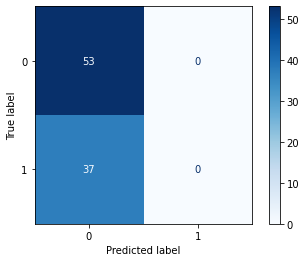

Melhor resultado de F1-score é 0.748 para um cutoff de 0.5000000000000001


In [23]:
dict={}
cutoff_list = np.arange(0.1, 1, 0.05)
for cutoff in cutoff_list:
    proba_1 = logit_cv.predict_proba(X_test)[:, 1]
    y_pred = np.where(proba_1 >= cutoff, 1, 0)
    logit_cm=confusion_matrix(y_test,y_pred)
    cr=classification_report(y_test, y_pred, output_dict=True)
    dict[cutoff] = cr['weighted avg']['f1-score']
    print('Cutoff: {}'.format(round(cutoff,2)))
    print(classification_report(y_test, y_pred))
    ConfusionMatrixDisplay(logit_cm).plot(cmap='Blues')
    plt.show()
print('Melhor resultado de F1-score é {} para um cutoff de {}'.format(round(max(dict.values()),3),(max(dict,key=dict.get))))  


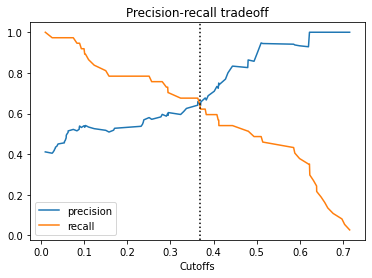

O ponto de melhor tradeoff precision-recall possui cutoff igual a [0.36757054]


In [28]:
y_proba_1 = logit_cv.predict_proba(X_test)[:, 1]
precisions, recalls, cutoffs = precision_recall_curve(y_test, y_proba_1)
plt.title("Precision-recall tradeoff")
plt.plot(cutoffs, precisions[:-1], label="precision")
plt.plot(cutoffs, recalls[:-1], label="recall")
plt.xlabel("Cutoffs")
ponto_de_encontro = cutoffs[np.where(precisions == recalls)]
plt.axvline(x=ponto_de_encontro, ls=":", color="k")
plt.legend()
plt.show()
print('O ponto de melhor tradeoff precision-recall possui cutoff igual a {}'.format(cutoffs[np.where(precisions == recalls)]))

Percebe-se que o melhor resultado para a média de f1-score é aquele com cutoff padrão. Entretanto, caso se deseje o melhor tradeoff precision-recall, é possível realizar a previsão com cutoff de 0.37.